In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# CSV 파일 로드
data_path = 'D:\\galaxy_classification\\data.csv'
image_dir = 'D:\\galaxy_classification\\images'

data = pd.read_csv(data_path)

# 클래스 매핑
class_mapping = {'S': 0, 'E': 1, 'SB': 2, 'EDGE': 3, 'STAR': 4}

# 데이터셋을 학습용과 검증용으로 분리
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# 데이터 제너레이터 생성 함수
def image_generator(data, batch_size, image_dir, class_mapping, augment=False):
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    ) if augment else ImageDataGenerator()

    num_samples = data.shape[0]
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples = data.iloc[offset:offset+batch_size]
            
            images = []
            labels = []
            for _, row in batch_samples.iterrows():
                image_id = row['image_id']
                label = row['class']
                
                # 이미지 파일 경로
                image_path = os.path.join(image_dir, f"{image_id}.jpg")
                
                # 이미지 로드 및 전처리
                if os.path.exists(image_path):
                    img = load_img(image_path, target_size=(128, 128))
                    img = img_to_array(img) / 255.0
                    images.append(img)
                    labels.append(class_mapping[label])
            
            X = np.array(images)
            y = to_categorical(np.array(labels), num_classes=len(class_mapping))
            
            if augment:
                yield next(datagen.flow(X, y, batch_size=batch_size))
            else:
                yield X, y

# 배치 사이즈 설정
batch_size = 64

train_generator = image_generator(train_data, batch_size, image_dir, class_mapping, augment=True)
val_generator = image_generator(val_data, batch_size, image_dir, class_mapping, augment=False)

# CNN 모델 정의
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(class_mapping), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [2]:
# 모델 훈련
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=6,  # 에포크 수 증가
    validation_data=val_generator,
    validation_steps=len(val_data) // batch_size,
    verbose=1
)

Epoch 1/6
2994/2994 [==============================] - 3079s 1s/step - loss: 1.1251 - accuracy: 0.5253 - val_loss: 1.1348 - val_accuracy: 0.5271
Epoch 2/6
2994/2994 [==============================] - 1975s 660ms/step - loss: 0.9501 - accuracy: 0.5872 - val_loss: 1.0033 - val_accuracy: 0.5725
Epoch 3/6
2994/2994 [==============================] - 1807s 604ms/step - loss: 0.8647 - accuracy: 0.6279 - val_loss: 0.8770 - val_accuracy: 0.6173
Epoch 4/6
2994/2994 [==============================] - 1732s 579ms/step - loss: 0.8290 - accuracy: 0.6453 - val_loss: 0.9176 - val_accuracy: 0.6102
Epoch 5/6
2994/2994 [==============================] - 1717s 574ms/step - loss: 0.8087 - accuracy: 0.6546 - val_loss: 0.7515 - val_accuracy: 0.6804
Epoch 6/6
2994/2994 [==============================] - 1727s 577ms/step - loss: 0.7974 - accuracy: 0.6606 - val_loss: 0.7267 - val_accuracy: 0.6893


In [3]:
# 모델 저장
model.save('D:\\galaxy_classification\\galaxy_classifier_ver5.h5')

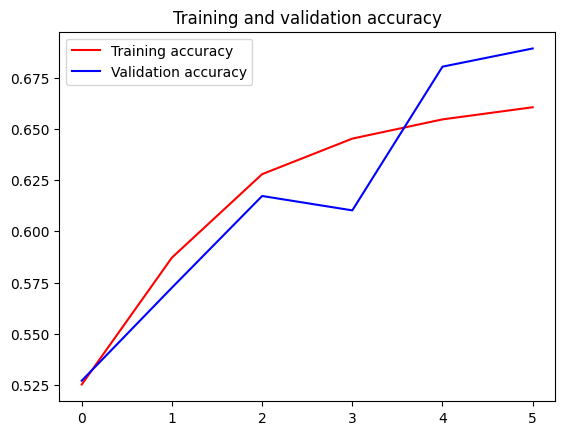

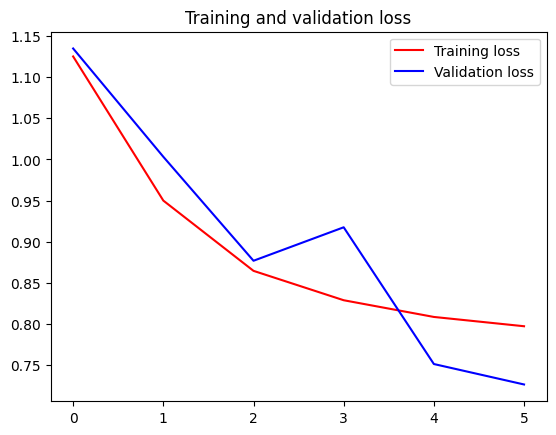

In [4]:
# 훈련 및 검증 정확도와 손실 그래프 그리기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

C:\Users\hyeonwoo\anaconda\envs\hw\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


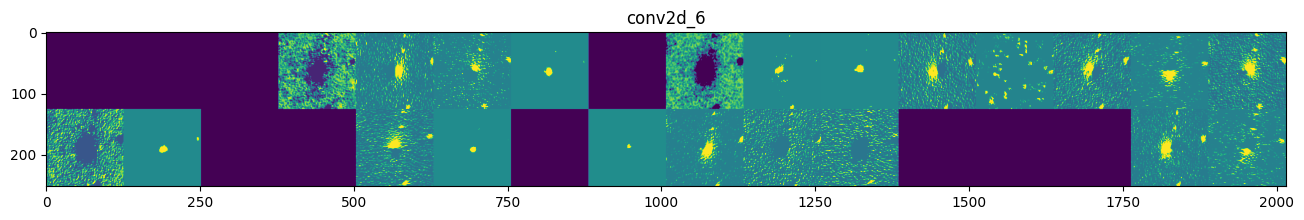

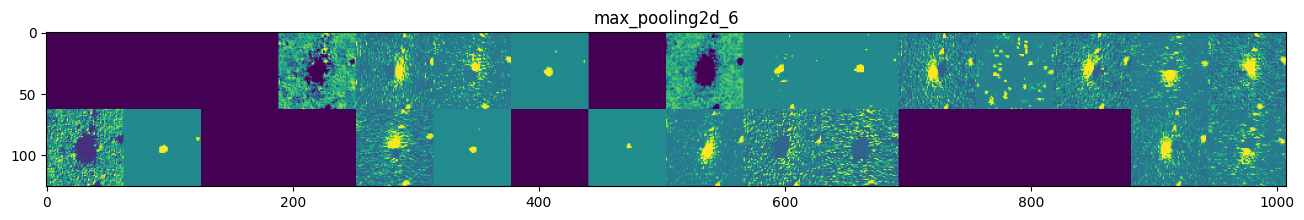

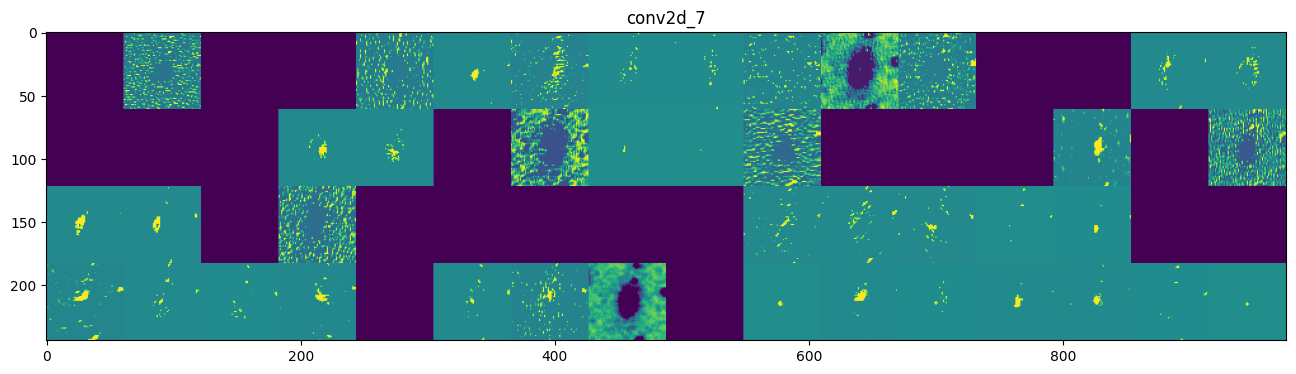

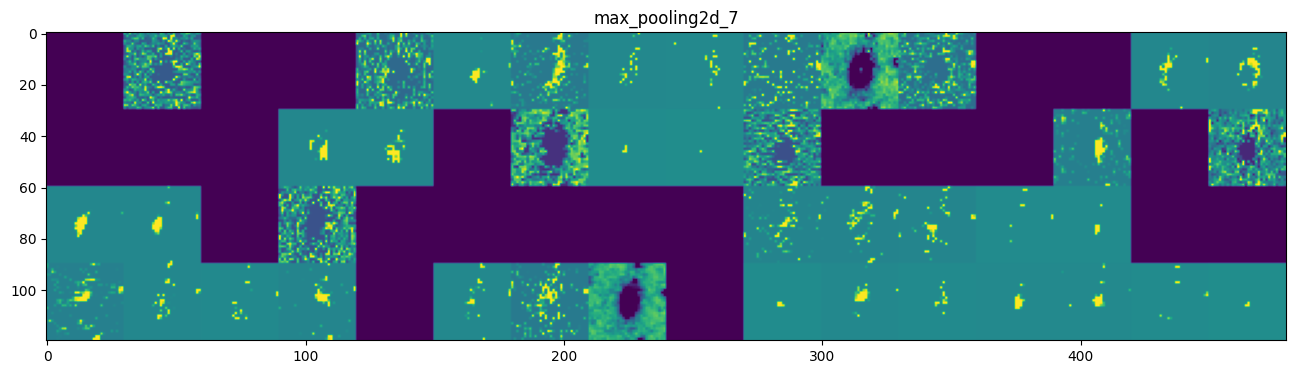

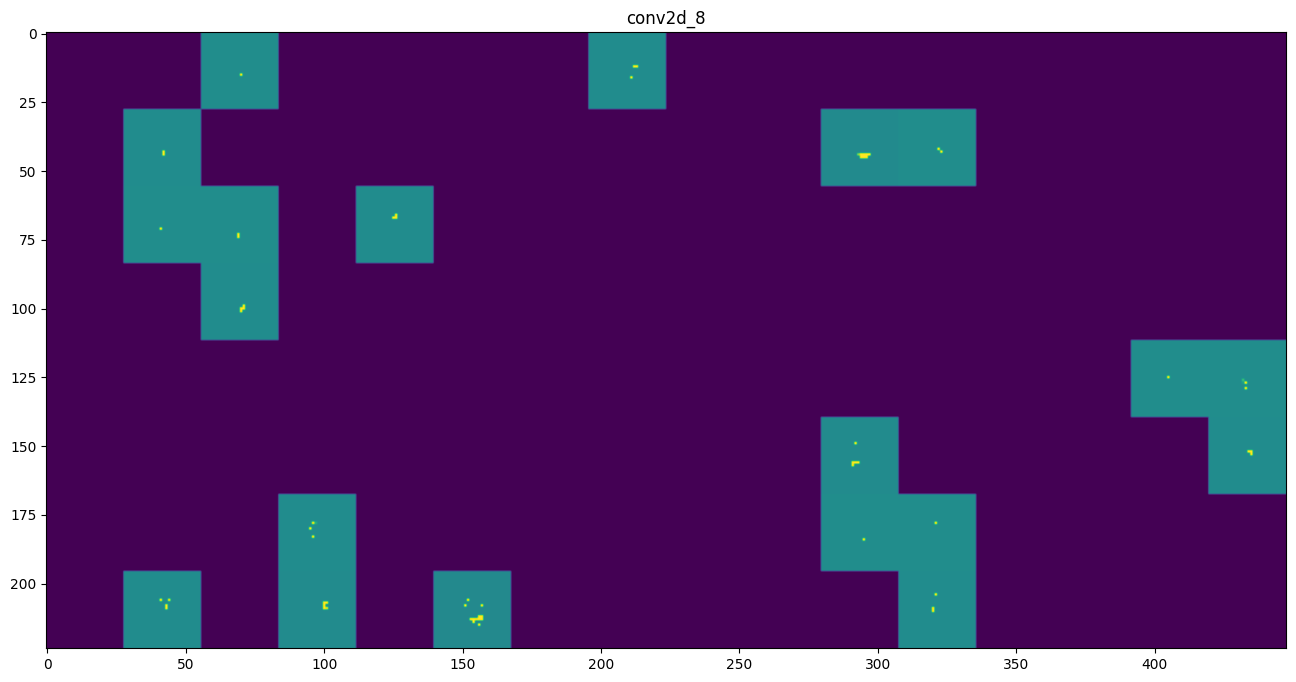

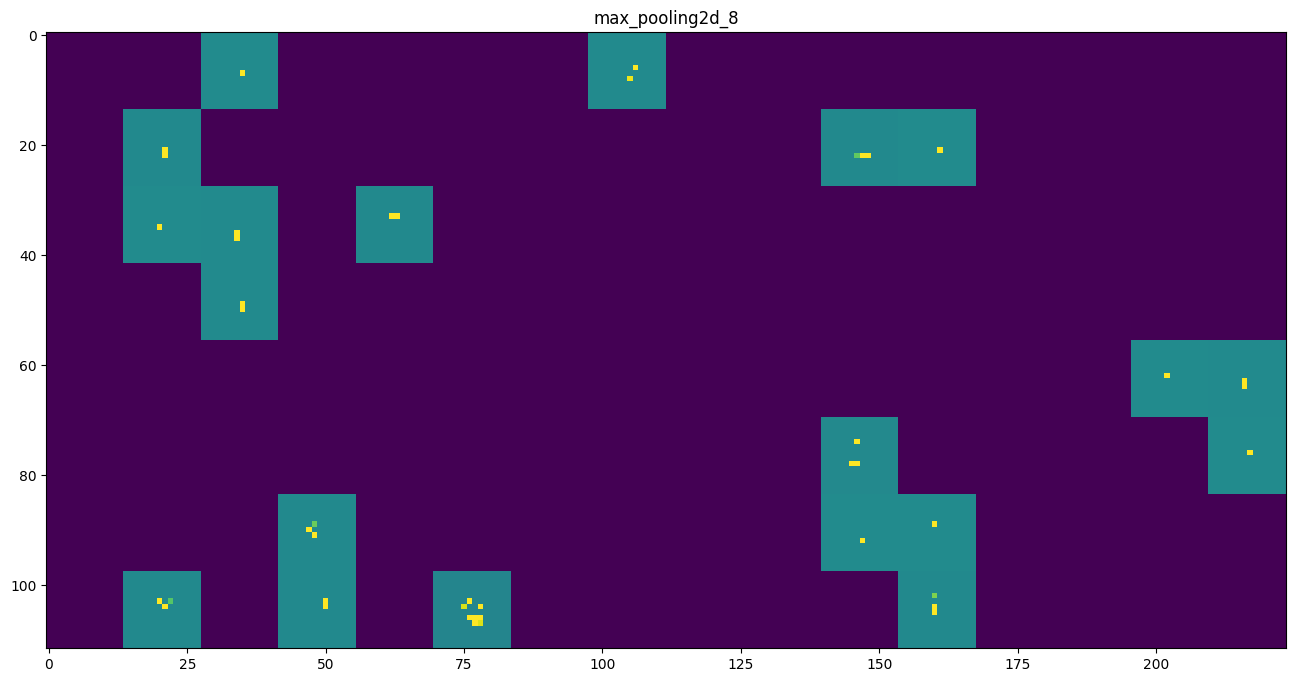

In [5]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# 데이터 경로
data_path = 'D:\galaxy_classification\data.csv'
image_dir = 'D:\galaxy_classification\images'

# CSV 파일 로드
data = pd.read_csv(data_path)

# 클래스 매핑
class_mapping = {'S': 0, 'E': 1, 'SB': 2, 'EDGE': 3, 'STAR': 4}

# 모델 불러오기
model_path = 'D:\galaxy_classification\galaxy_classifier.h5'
model = load_model(model_path)

# 특정 레이어의 출력을 추출하는 모델 정의
layer_outputs = [layer.output for layer in model.layers[:6]] # 첫 6개의 레이어 선택 (Conv, ReLU, Pooling)
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# 이미지 선택 및 전처리
image_id = data.iloc[0]['image_id']  # 예시로 첫 번째 이미지 사용
img_path = os.path.join(image_dir, f"{image_id}.jpg")
img = load_img(img_path, target_size=(128, 128))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# 활성화 맵 계산
activations = activation_model.predict(img_array)

# 활성화 맵 시각화
layer_names = []
for layer in model.layers[:6]:
    layer_names.append(layer.name)  # 각 레이어의 이름 저장

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]  # 특성 맵의 수
    size = layer_activation.shape[1]  # 특성 맵의 크기
    n_cols = n_features // images_per_row  # 특성 맵을 그릴 열 수
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()  # 시각화를 위한 표준화
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()